# <u> New York City Motor Vehicle Crashes from 2012-2014 </u>

In [1]:
import numpy as np
import pandas as pd

import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus

import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# <u> Data Set Description </u>

Data from: https://catalog.data.gov/dataset/motor-vehicle-crashes-vehicle-information-beginning-2009

This dataset <b>MV</b> contains one row for every car that had crashed in New York City.  

Important columns in <b>MV</b> are:
<ul>
<li><b>Year</b>: Calendar year in which accident occured
<li><b>Vehicle Body Type</b>: Classification of vehicle determining size, shape, cargo capacity etc.
<li><b>Action Prior to Accident</b>: Vehicle / Driver's maneuver or situation prior to accident occurence
<li><b>Vehicle Year</b>: Year of vehicle's manufacture
<li><b>Number of Occupants</b>: Number of riders inside the vehicle
<li><b>Vehicle Make</b>: Vehicle Manufacturer name
<li><b>Contributing Factor 1</b>: Classification of contributing factor description
<li><b>Contributing Factor 1 Description</b>: Details of what contributed to accident occurence
</ul>

In [2]:
keepCols = ['Year','Vehicle Body Type', 'Vehicle Make', 'Action Prior to Accident', 'Vehicle Year', 'Number of Occupants',
           'Contributing Factor 1', 'Contributing Factor 1 Description']

MV = pd.read_csv('Motor_Vehicle_Crashes_-_Vehicle_Information__Three_Year_Window.csv',usecols=keepCols)

In [3]:
MV.head(2)

,Year,Vehicle Body Type,Action Prior to Accident,Vehicle Year,Number of Occupants,Vehicle Make,Contributing Factor 1,Contributing Factor 1 Description
0,2013,2 DOOR SEDAN,Backing,2013.0,1.0,HOND,HUMAN,Backing Unsafely
1,2013,4 DOOR SEDAN,Overtaking/Passing,2013.0,1.0,DODG,HUMAN,Unsafe Lane Changing


# <u> Data Preparation </u>

### Vehicle Year

Bin vehicle years into decades for easier analysis, because there are too many specific vehicle years

In [4]:
MV['Vehicle Decade'] = np.nan

MV.loc[MV['Vehicle Year'] <= 1959, 'Vehicle Decade'] = 1950
MV.loc[(MV['Vehicle Year'] > 1959) & (MV['Vehicle Year'] <= 1969), 'Vehicle Decade'] = 1960
MV.loc[(MV['Vehicle Year'] > 1969) & (MV['Vehicle Year'] <= 1979), 'Vehicle Decade'] = 1970
MV.loc[(MV['Vehicle Year'] > 1979) & (MV['Vehicle Year'] <= 1989), 'Vehicle Decade'] = 1980
MV.loc[(MV['Vehicle Year'] > 1989) & (MV['Vehicle Year'] <= 1999), 'Vehicle Decade'] = 1990
MV.loc[(MV['Vehicle Year'] > 1999) & (MV['Vehicle Year'] <= 2009), 'Vehicle Decade'] = 2000
MV.loc[(MV['Vehicle Year'] > 2009) & (MV['Vehicle Year'] <= 2019), 'Vehicle Decade'] = 2010

### Contributing Factors

The original dataset has a second Contributing Factor column, named 'Contributing Factor 2'  
Because we think it gives no new information compared to 'Contriubting Factor 1', we decided not to use it.  
We can assume 'Contributing Factor 1' is the more important contrbuting factor of the two, because in a car accident one would think of a second Contributing Factor entry as just optional.  
Also a 2nd column that can contain the same possible values confuses the reader.

By default all 57 possible contributing factors are aggregated into 3 categories: <u>Human</u>, <u>Environment</u>, and <u>Vehicle</u>  
We found these categories unhelpful and lacking, so we created 4 new aggregations: <u>Unsafe Driving</u>, <u>Distracted Driving</u>, <u>Poor Environment</u> and <u>Car Defect</u>

In [5]:
# Unsafe Driving
Unsafe = ['Passing or Lane Usage Improper', 'Following Too Closely', 'Failure to Yield Right-of-Way', 
          'Failure to Keep Right', 'Unsafe Lane Changing', 'Unsafe Speed', 'Turning Improperly', 
          'Traffic Control Device Disregarded', 'Driver Inexperience*', 'Backing Unsafely', 
         'Aggressive Driving/Road Rage', 'Passing Too Closely']

# Distracted Driving
Distract = ['Driver Inattention/Distraction*', 'Fell Asleep', 'View Obstructed/Limited', 'Passenger Distraction', 
            'Fatigued/Drowsy', 'Prescription Medication', 'Other Electronic Device*', 'Illness', 'Alcohol Involvement', 
           'Using On Board Navigation Device', 'Cell Phone (hand held)', 'Outside Car Distraction*', 'Lost Consciousness', 
           'Drugs (Illegal)', 'Texting', 'Eating or Drinking', 'Listening/Using Headphones', 'Cell Phone (hands-free)']

# Poor Environment
Enviro = ['Pavement Slippery', "Animal's Action", 'Shoulders Defective/Improper', 'Obstruction/ Debris', 
         'Pavement Defective', 'Traffic Control Device Improper/Non-Working', 'Lane Marking Improper/Inadequate', 
         'Oversized Vehicle', 'Reaction to Other Uninvolved Vehicle', 'Glare', 'Other Lighting Defects', 
         'Pedestrian/Bicyclist Error/Confusion', 'Driverless/Runaway Vehicle']

# Car Defects
Defect = ['Tire Failure/Inadequate', 'Brakes Defective', 'Tow Hitch Defective', 'Steering Failure', 'Accelerator Defective', 
         'Headlights Defective', 'Windshield Inadequate', 'Tinted Windows']

# Uncategorized: 'Not Applicable', 'Not Entered', 'Unknown', 'Other*', 'Other', nan, 'Physical Disability'

In [6]:
MV['Contributing Factor 1'] = np.nan  # Erase old factor categories

In [7]:
# Insert new categories
MV.loc[MV['Contributing Factor 1 Description'].isin(Unsafe),'Contributing Factor 1'] = 'Unsafe Driving'
MV.loc[MV['Contributing Factor 1 Description'].isin(Distract),'Contributing Factor 1'] = 'Distracted Driving'
MV.loc[MV['Contributing Factor 1 Description'].isin(Enviro),'Contributing Factor 1'] = 'Poor Environment'
MV.loc[MV['Contributing Factor 1 Description'].isin(Defect),'Contributing Factor 1'] = 'Defective Vehicle'

### Action Prior to Accident

Create two new columns from this original column.
* First column aggregates actions into 4 categories of actions

In [8]:
Moving = ['Overtaking/Passing', 'Going Straight Ahead','Changing Lanes', 'Merging',
                   'Avoiding Object in Roadway','Police Pursuit']

Turning = ['Making Left Turn', 'Making Right Turn', 'Making U Turn', 
                   'Making Left Turn on Red', 'Making Right Turn on Red']

StoppedOrSlow = ['Slowing or Stopping', 'Stopped in Traffic', 'Starting from Parking', 
                   'Starting in Traffic']

Parking = ['Backing', 'Parked', 'Entering Parked Position']

# Not categorized: 'Other', 'Not Applicable', 'Not Entered', 'Unknown'

In [9]:
MV['Action_Prior'] = np.nan

MV.loc[MV['Action Prior to Accident'].isin(Moving),'Action_Prior'] = 'Moving Straight'
MV.loc[MV['Action Prior to Accident'].isin(Turning),'Action_Prior'] = 'Turning'
MV.loc[MV['Action Prior to Accident'].isin(StoppedOrSlow),'Action_Prior'] = 'Stopped/Slow'
MV.loc[MV['Action Prior to Accident'].isin(Parking),'Action_Prior'] = 'Parking'

* Second column further condenses those 4 categories into speed of travel (Fast/Slow)

In [10]:
MV['Speed_Bin'] = 0
MV.loc[(MV['Action_Prior'] == 'Moving') | (MV['Action_Prior'] == 'Turning'), 'Speed_Bin'] = 1

### Number of Occupants

Pad NANs - Every row with vehicle body type Pedestrian must have Number of Occupants == 1

In [11]:
MV[MV['Vehicle Body Type'] == 'PEDESTRIAN']['Number of Occupants'].unique()

array([ nan,   1.])

In [12]:
MV.loc[MV['Vehicle Body Type'] == 'PEDESTRIAN','Number of Occupants'] = 1

## Final Cleaned Dataset:

In [13]:
MV.head(1)

,Year,Vehicle Body Type,Action Prior to Accident,Vehicle Year,Number of Occupants,Vehicle Make,Contributing Factor 1,Contributing Factor 1 Description,Vehicle Decade,Action_Prior,Speed_Bin
0,2013,2 DOOR SEDAN,Backing,2013.0,1.0,HOND,Unsafe Driving,Backing Unsafely,2010.0,Parking,0


# <u> Finding #1 - Bicycles vs Motorcycles </u>

## <u> Summary: </u>
Bicycles see more accidents from poor environments while motorcycles see more accidents from unsafe driving.  
In addition both bicycles and motorcycles are seeing reductions in poor environment accidents over time, while unsafe driving is on the rise.

## <u> Machine Learning: Clustering </u>

Clustering was able to group bicycles and motorcycles each into their own clusters. Through the clusters we were able to compare and contrast common crash characteristics for each.

In [14]:
Finding1 = MV[(MV['Vehicle Body Type'].isin(['BICYCLIST','MOTORCYCLE']))]

There are roughly similar number of motorcycle and bicycle incidents, so there will be minimal bias

In [15]:
Finding1['Vehicle Body Type'].value_counts()

BICYCLIST     18386
MOTORCYCLE    16267
Name: Vehicle Body Type, dtype: int64

In [16]:
Finding1 = Finding1.drop(['Vehicle Year', 'Vehicle Make', 'Contributing Factor 1 Description', 
                          'Action Prior to Accident', 'Vehicle Decade'],axis=1)

In [17]:
Finding1 = pd.get_dummies(data=Finding1, columns=['Vehicle Body Type', 'Contributing Factor 1', 'Action_Prior'])

In [18]:
Finding1.dropna(inplace=True)

In [19]:
from sklearn.cluster import KMeans

In [20]:
clu = KMeans(n_clusters=2,random_state=0)

In [21]:
clu.fit(Finding1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [22]:
Finding1['cluster'] = clu.labels_

In [23]:
Finding1.groupby('cluster').mean().T

cluster,0,1
Year,2012.983406,2012.933115
Number of Occupants,1.005277,1.083491
Speed_Bin,0.064255,0.080876
Vehicle Body Type_BICYCLIST,1.000000,0.000000
Vehicle Body Type_MOTORCYCLE,0.000000,1.000000
Contributing Factor 1_Defective Vehicle,0.005441,0.011638
Contributing Factor 1_Distracted Driving,0.071926,0.084472
Contributing Factor 1_Poor Environment,0.231338,0.168290
Contributing Factor 1_Unsafe Driving,0.166703,0.312913
Action_Prior_Moving Straight,0.756583,0.783916


Motorcycles see more unsafe driving than bicycles.  
Bicycles are more prone to environmental hazards than motorcycles.  
All other contributing factors and actions prior see minimal differences or is obvious.
One obvious trivial observation is that motorcycles move faster on average than motorcycles.

It appears the rates of occurence per calendar year are about the same for each body type, but if we increase the number of clusters from 2 to 4....

In [24]:
clu = KMeans(n_clusters=4,random_state=0)

In [25]:
clu.fit(Finding1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [26]:
Finding1['cluster'] = clu.labels_

In [27]:
Finding1.groupby('cluster').mean().T

cluster,0,1,2,3
Year,2012.000000,2013.481574,2012.000000,2013.479254
Number of Occupants,1.093606,1.077546,1.004058,1.005892
Speed_Bin,0.086542,0.077546,0.065898,0.063426
Vehicle Body Type_BICYCLIST,0.000000,0.000000,1.000000,1.000000
Vehicle Body Type_MOTORCYCLE,1.000000,1.000000,0.000000,0.000000
Contributing Factor 1_Defective Vehicle,0.011833,0.011523,0.004220,0.006056
Contributing Factor 1_Distracted Driving,0.088308,0.082217,0.064762,0.075538
Contributing Factor 1_Poor Environment,0.166019,0.169625,0.245252,0.224323
Contributing Factor 1_Unsafe Driving,0.306782,0.316516,0.154845,0.172682
Action_Prior_Moving Straight,0.782409,0.784802,0.764811,0.752435


... then the clusters would divide each vehicle body type between two years, showing an increased rate of Unsafe Driving crashes for both bicycles and motorcycles over time.

## <u> Validating the Finding </u>

These charts show rates of unsafe driving and poor environment incidents over time for each vehicle body type.  
Take note of the slopes of lines between years. The slopes for motorcycles are subtle but the absolute values of the slopes are definitely greater than zero.

In [28]:
F4SB = MV[(MV['Vehicle Body Type'].isin(['BICYCLIST','MOTORCYCLE']))]

In [29]:
F4SB = F4SB[F4SB['Contributing Factor 1'].isin(['Poor Environment','Unsafe Driving'])]

In [30]:
F4SB = pd.get_dummies(F4SB,columns=['Contributing Factor 1'])

This chart validates that Motorcycles see many more Unsafe Driving incidents than Bicycles,  
but Bicycles rates are catching up to Motorcycle rates.

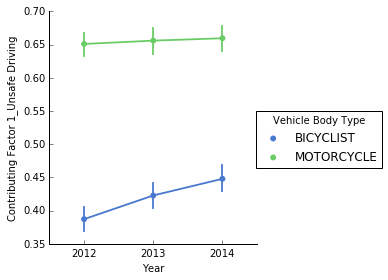

In [31]:
sns.factorplot(y='Contributing Factor 1_Unsafe Driving',x='Year',hue='Vehicle Body Type',
               data=F4SB,kind='point',palette="muted")

This chart validates that Bicycles see more Poor Environment incidents than Motorcycles,
but Poor Environment incident rates are dropping for both.

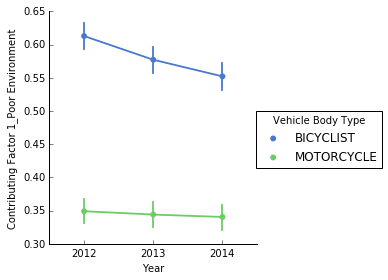

In [32]:
sns.factorplot(y='Contributing Factor 1_Poor Environment',x='Year',hue='Vehicle Body Type',
               data=F4SB, kind='point',palette="muted")

## <u> Managerial Insight </u>

Unsafe Driving is becoming the norm for accident contributing factors among motorcycles and bicycles.  My speculation is:
* Quality of environment may be improving over time, so this could be motivating bicyclists and motorcycle riders to be overconfident in their abilities on the road.  
* New York City is known for its many jay-walking pedestrians who ignore traffic laws.  Motorcycles and Bicycles may have picked up their bad habits.  

New York City's Police Department should be stricter in enforcing traffic law compliance for both bicycles and motorcycles, in order to ensure a safer environment for every inhabitant of New York City

# <u> Finding #2 - 4 Door Sedans vs. Suburbans </u>

## <u> Summary: </u>

Even though Suburbans are commonly considered safer than sedans due to their increased size and relatively lower accident count, Suburbans are more prone to indulging in an accident when the driver is backing.

However, among crashed cars that were backing, 4-Door Sedans have a higher chance of crashing from failure to yield right-of-way than Suburbans.

## <u> Machine Learning: Classfication </u>

Using a decision tree, we were able to simulate a chain of events scenario to classify what vehicle body type corresponds to a given combination of driving behavior, between an action prior to accident and contributing factors.

In [33]:
F2 = MV[['Vehicle Body Type', 'Action Prior to Accident', 'Contributing Factor 1 Description']].copy()

In [34]:
F2.replace(to_replace=['Not Entered', 'Unknown', 'Not Applicable', 'OTHER', 'OTHER*','Other*', 
                       'OTHER VEHICLE', 'UNKNOWN VEHICLE', 'UNKNOWN CAR',
                       'UNKNOWN TRUCK', 'CUSTOM'],value=np.nan,inplace=True)

In [35]:
F2 = F2[F2['Vehicle Body Type'].isin(['4 DOOR SEDAN','SUBURBAN'])]

In [36]:
F2_Tree = pd.get_dummies(F2,columns=['Action Prior to Accident','Contributing Factor 1 Description'])

In [37]:
X = F2_Tree.drop('Vehicle Body Type', axis=1)

In [38]:
Y = F2_Tree['Vehicle Body Type']

In [39]:
dt = tree.DecisionTreeClassifier(max_depth=2)

In [40]:
dt.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

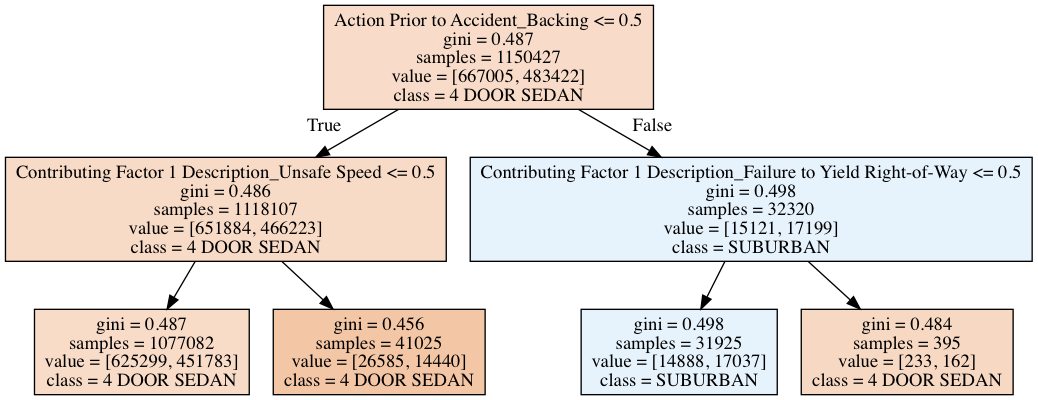

In [41]:
dt_feature_names = list(X.columns)
dt_target_names = sorted(np.array(Y.unique(),dtype=np.string_)) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

Here we see on the left tree branch, given a car is NOT backing, a car accident in question is more likely to involve a 4-Door Sedan than Suburban.  
But among backing cars, more 4-Door Sedans fail to yield right of way.

## <u> Validating the Finding </u>

We have turned the Vehicle Body Type into a binary variable.  
The Y-axis in these charts is a percentage scale showing average of the binary variable 'Vehicle Body Type_SUBURBAN':
* 1 = Suburban
* 0 = 4-Door Sedan  

The blue bars in this chart describe the left branch of the decision tree.  
Suburbans account for less than 50% of accidents between the two body types when not backing, regardless of unsafe speed.  
4-Door Sedans account for over 50% of accidents here.

In [42]:
F2_SB = pd.get_dummies(F2_Tree,columns=['Vehicle Body Type'])

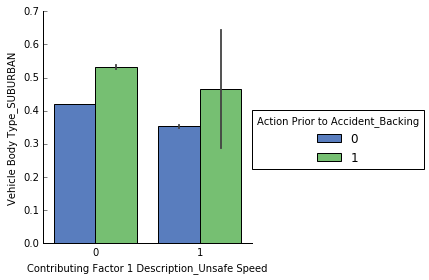

In [43]:
sns.factorplot(x='Contributing Factor 1 Description_Unsafe Speed',
               hue='Action Prior to Accident_Backing',
               y='Vehicle Body Type_SUBURBAN',data=F2_SB, aspect=1,kind='bar',palette='muted')

Here the green bars describe the right branch of the decision tree.  
If Failure to Yield = 1, less than 50% Suburbans are involved (aka - more than 50% 4-Door Sedans involved).  
If Failure to Yield = 0, more than 50% Suburbans are involved (aka - less than 50% 4-Door Sedans involved).

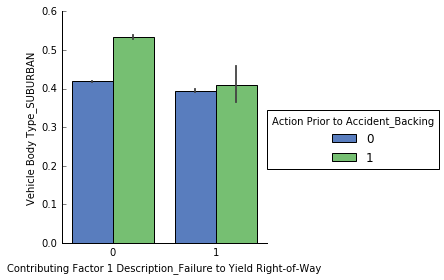

In [44]:
sns.factorplot(x='Contributing Factor 1 Description_Failure to Yield Right-of-Way',
               hue='Action Prior to Accident_Backing',
               y='Vehicle Body Type_SUBURBAN',data=F2_SB, aspect=1,kind='bar',palette='muted')

## <u> Managerial Insight </u>

To address unfavorable backing behavior, Suburban manufacturers should deploy better safety measures for preventing such accidents, such as rear view cameras, blind spot monitoring systems or warning alarms.  

How would 4 door sedans, among all backing cars, have more trouble yielding right of way?  We speculate that:
* Sedan drivers may have increased confidence on the road than suburban drivers due to their smaller size for navigating small roads, better visibility of suroundings, and lighter weight for ease of mobility.  Overconfidence can lead impatience as well as the misjudgement of traffic situations
* A smaller car providing better surrounding visibility than big cars, is no less prone to accidents.  Smaller cars need modern driver assistance and safety technologies just as much as bigger cars do.

# <u> Finding #3 - Honda vs Toyota Car Defects </u>

## <u> Summary: </u>

In recent time, the Japanese vehicle manufacturer Toyota is infamous for accelerator problems in their cars.  
However, close competitor Honda also has accelerator problems in their cars, with failure rates similar to Toyotas in certain years of manufacture.  
Hondas also have a higher rate of power steering failure than Toyotas.

## <u> Machine Learning: Clustering and Classification </u>

Clustering was able to group Hondas and Toyotas into their own clusters.  Through that we can compare and contrast car defect rates in each manufacturer.

In [45]:
F3 = MV[['Vehicle Make', 'Vehicle Decade', 'Contributing Factor 1 Description']]

In [46]:
F3 = F3[F3['Contributing Factor 1 Description'].isin(['Tow Hitch Defective', 'Brakes Defective', 
            'Steering Failure', 'Accelerator Defective', 'Headlights Defective', 'Windshield Inadequate'])]

In [47]:
Makes = ['TOYOT','HONDA']
F3 = F3[F3['Vehicle Make'].isin(Makes)]

In [48]:
F3Clu = pd.get_dummies(F3,columns=['Vehicle Make', 'Contributing Factor 1 Description'])
F3Clu = F3Clu.drop('Vehicle Decade',axis=1)

In [49]:
from sklearn.cluster import KMeans

In [50]:
clu = KMeans(n_clusters=2,random_state=0)

In [51]:
clu.fit(F3Clu)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [52]:
F3Clu['cluster'] = clu.labels_

In [53]:
F3Clu.groupby('cluster').mean().T

cluster,0,1
Vehicle Make_HONDA,0.000000,1.000000
Vehicle Make_TOYOT,1.000000,0.000000
Contributing Factor 1 Description_Accelerator Defective,0.189189,0.140056
Contributing Factor 1 Description_Brakes Defective,0.540541,0.515406
Contributing Factor 1 Description_Headlights Defective,0.015766,0.022409
Contributing Factor 1 Description_Steering Failure,0.225225,0.310924
Contributing Factor 1 Description_Tow Hitch Defective,0.015766,0.005602
Contributing Factor 1 Description_Windshield Inadequate,0.013514,0.005602


Toyotas see a higher rate of defective accelerators.  
Hondas see a higher rate of steering failures.

Looking at correlations:

In [54]:
F3Clu = F3Clu[['Vehicle Make_HONDA', 'Vehicle Make_TOYOT', 'Contributing Factor 1 Description_Accelerator Defective',
              'Contributing Factor 1 Description_Steering Failure']]

In [55]:
F3Clu.corr()

,Vehicle Make_HONDA,Vehicle Make_TOYOT,Contributing Factor 1 Description_Accelerator Defective,Contributing Factor 1 Description_Steering Failure
Vehicle Make_HONDA,1.000000,-1.000000,-0.065431,0.096702
Vehicle Make_TOYOT,-1.000000,1.000000,0.065431,-0.096702
Contributing Factor 1 Description_Accelerator Defective,-0.065431,0.065431,1.000000,-0.268043
Contributing Factor 1 Description_Steering Failure,0.096702,-0.096702,-0.268043,1.000000


Probability of Honda is positively correlated with steering failure, negatively correlated with defective accelerators.  
Probability of Toyota is positively correlated with defective accelerators, negatively correlated with steering failures.

A decision tree also backs our claim, where we see that most non-steering related defects are Toyotas rather than Hondas, while steering failures are most likely Hondas. 

In [56]:
F3Tree = pd.get_dummies(F3,columns=['Contributing Factor 1 Description'])
F3Tree = F3Tree.drop('Vehicle Decade',axis=1)

In [57]:
X = F3Tree.drop(['Vehicle Make'],axis=1)
Y = F3Tree['Vehicle Make']

In [58]:
dt = tree.DecisionTreeClassifier(max_depth=2)
dt.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

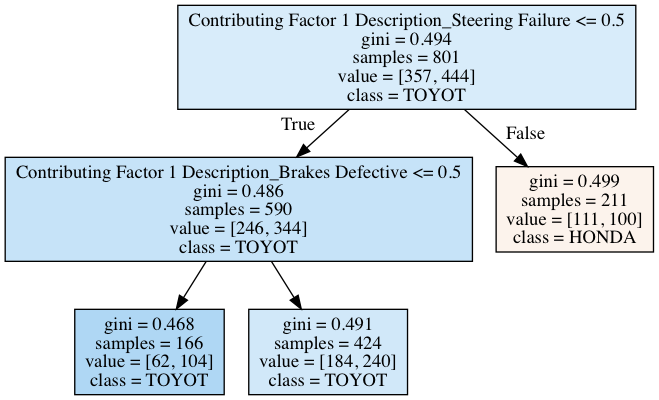

In [59]:
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

We considered adding vehicle years into machine learning, but the classifications and clusters place too much importance on vehicle year to predict vehicle manufacturer, which was not our primary concern - our primary concern was to match defects with manufacturers.

We have added vehicle years as an additional dimension in our seaborn validations to explore in greater detail what specific defects affect which vehicle years.

## Validating the Finding

In [60]:
F3SB = pd.get_dummies(F3,columns=['Contributing Factor 1 Description'])

This chart shows rates of accelerator defect for each vehicle make and decade of car's manufacturer.  
Clearly, Toyotas have more accelerator defects than Hondas across all years of car manufacture later than 1980, but Hondas in the 1990s and 2000s also have failure rates dangerously similar to that of Toyotas.

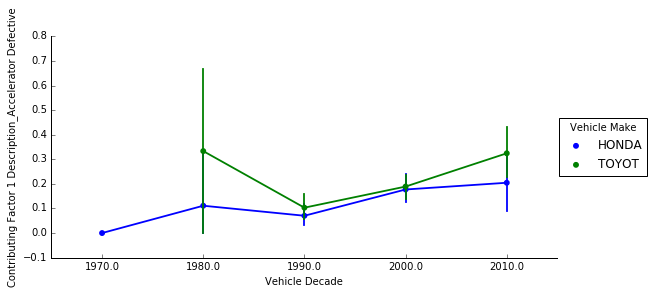

In [61]:
sns.factorplot(x='Vehicle Decade',
               y='Contributing Factor 1 Description_Accelerator Defective',
               hue='Vehicle Make',
              data=F3SB, kind='point',aspect=2)

This chart shows probabilites of a defect being a steering failure for each vehicle make and decade of a car's manufacture.  
Honda has higher rates of steering failure than Toyota across all years of vehicle manufacture.

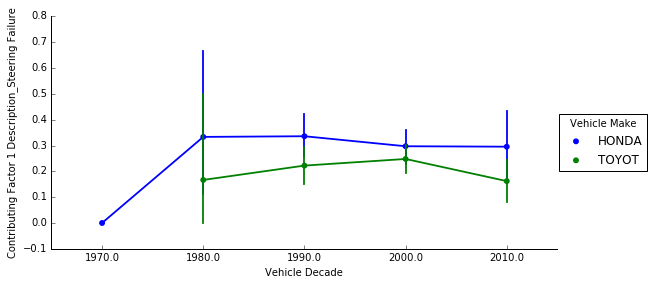

In [62]:
sns.factorplot(x='Vehicle Decade',
               y='Contributing Factor 1 Description_Steering Failure',
               hue='Vehicle Make',
              data=F3SB, kind='point', aspect=2)

## Managerial Insight

Just because Toyota garnered plenty of bad publicity from their accelerator problems, does not mean other manufacturers can relax and worry less about competition.  Because other manufacturers can have defects in aspects of a car other than accelerators, that Toyota may not need to worry about.  

In this case, Honda needs to take care of their steering problems to be sure their reputation does not fall as badly as Toyota's reputation.  Honda also has accelerator failure rates very similar to Toyota's failure rates for cars made in the 1990s and 2000s, so they could have easily taken the same reputational damage Toyota did.  

Maintaining a reputation is necessary to keep sales and stock prices high, while also maintaining attractiveness to investors and creditors to maintain desirability to invest in a car company.